In [118]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [119]:
class Value:
    def __init__ (self, data, _children = (), _op = '', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._backward = lambda : None
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __radd__(self, other):
        return self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self, other):  #other * self
        return self * other
    
    def __pow__(self, other): 
        assert isinstance(other, (int, float)), "only supporting integer and float power function as of now"
        out = Value(self.data**other, (self, ), f'**{other}')
       
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out
    
    def __truediv__(self, other): #self / other
        return self * (other**-1)
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)


        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            v.grad = 0.0
            if v not in visited:
                visited.add(v)
                for c in v._prev:
                    build_topo(c)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for n in reversed(topo):
            n._backward()

In [120]:
a = Value (2.0)
b = Value(4.0)
a/b

Value(data=0.5)

In [121]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad ), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

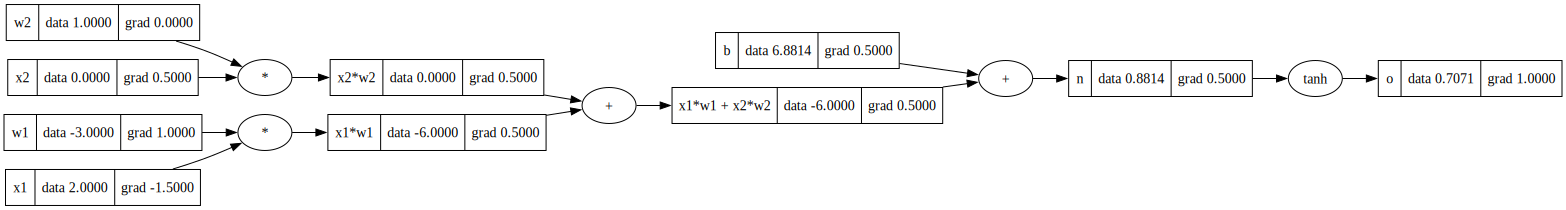

In [122]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

o=n.tanh(); o.label = 'o'; o.backward()

draw_dot(o)

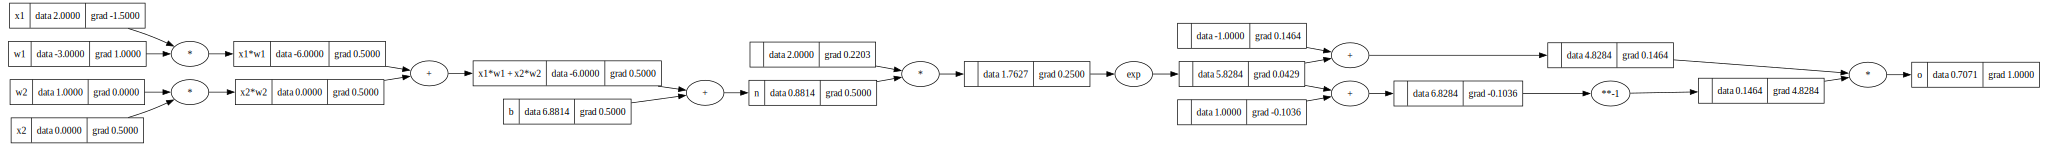

In [123]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'


e = (2*n).exp()
o = (e - 1) / (e + 1)
o.label = 'o'; o.backward()

draw_dot(o)

In [124]:
import torch
import random

In [125]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [126]:
class Neuron:  
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum([wi * xi for wi, xi in zip(self.w, x)], self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
       return self.w + [self.b]
    
class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]
  
class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
     return [p for layer in self.layers for p in layer.parameters()] 


In [147]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])  
n(x)
n.parameters()


[Value(data=-0.25254938308266195),
 Value(data=0.6346843404076996),
 Value(data=0.17537208672109572),
 Value(data=-0.6484907833803066),
 Value(data=-0.35166441972738016),
 Value(data=0.5257483412002322),
 Value(data=-0.954544538169342),
 Value(data=0.8727885266382089),
 Value(data=-0.7207243165607025),
 Value(data=-0.9857950518752907),
 Value(data=-0.15997485021123525),
 Value(data=0.13045627320978004),
 Value(data=-0.06970093454245974),
 Value(data=0.3920417911989824),
 Value(data=-0.08158637137440317),
 Value(data=0.011314313508610674),
 Value(data=0.4775856148615585),
 Value(data=-0.31641006766976965),
 Value(data=-0.3603019495433566),
 Value(data=0.941690793809993),
 Value(data=0.6254595791660609),
 Value(data=0.7074068843354013),
 Value(data=0.8552649227853169),
 Value(data=0.16967221861820692),
 Value(data=-0.6661818307974303),
 Value(data=0.10355601371377299),
 Value(data=0.9793824939538871),
 Value(data=0.5993995198932238),
 Value(data=0.7362038803321558),
 Value(data=0.5054258

In [148]:
xs = [
    [2.0, 3.0, -1.0], 
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]

In [129]:
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss

Value(data=5.018290146768796)

In [153]:
for k in range(100000):
    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])

    #backward pass
    loss.backward()

    #update
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)
    
loss

0 0.0004442535739225107
1 0.00044384025104959055
2 0.00044342768943028633
3 0.000443015886969833
4 0.0004426048415811285
5 0.00044219455118470544
6 0.00044178501370868863
7 0.000441376227088763
8 0.00044096818926814176
9 0.00044056089819753403
10 0.00044015435183510576
11 0.0004397485481464551
12 0.00043934348510456256
13 0.0004389391606897686
14 0.0004385355728897391
15 0.00043813271969943914
16 0.00043773059912108315
17 0.0004373292091641131
18 0.00043692854784517103
19 0.00043652861318805604
20 0.00043612940322368117
21 0.0004357309159900865
22 0.00043533314953235036
23 0.0004349361019025985
24 0.00043453977115994505
25 0.0004341441553704914
26 0.00043374925260726007
27 0.00043335506095020296
28 0.00043296157848612255
29 0.0004325688033086778
30 0.00043217673351835905
31 0.00043178536722242056
32 0.00043139470253488236
33 0.00043100473757648125
34 0.0004306154704746563
35 0.00043022689936351234
36 0.0004298390223837778
37 0.00042945183768280134
38 0.0004290653434145018
39 0.00042867

Value(data=4.3557424243105115e-06)

In [154]:
ypred = [n(x) for x in xs]
ypred

[Value(data=0.999270393311275),
 Value(data=-0.998707245566847),
 Value(data=-0.9989811369837519),
 Value(data=0.9989445018299961)]